Época: 0/5000	Função custo: 2.999E+00
Época: 50/5000	Função custo: 7.894E-01
Época: 100/5000	Função custo: 1.921E-03
Época: 150/5000	Função custo: 4.565E-04
Época: 200/5000	Função custo: 3.131E-04
Época: 250/5000	Função custo: 2.380E-04
Época: 300/5000	Função custo: 1.925E-04
Época: 350/5000	Função custo: 1.616E-04
Época: 400/5000	Função custo: 1.381E-04
Época: 450/5000	Função custo: 1.189E-04
Época: 500/5000	Função custo: 1.028E-04
Época: 550/5000	Função custo: 8.898E-05
Época: 600/5000	Função custo: 7.704E-05
Época: 650/5000	Função custo: 6.668E-05
Época: 700/5000	Função custo: 5.765E-05
Época: 750/5000	Função custo: 4.979E-05
Época: 800/5000	Função custo: 4.296E-05
Época: 850/5000	Função custo: 3.705E-05
Época: 900/5000	Função custo: 3.194E-05
Época: 950/5000	Função custo: 2.755E-05
Época: 1000/5000	Função custo: 2.380E-05
Época: 1050/5000	Função custo: 2.059E-05
Época: 1100/5000	Função custo: 1.787E-05
Época: 1150/5000	Função custo: 1.556E-05
Época: 1200/5000	Função custo: 1.359E-0

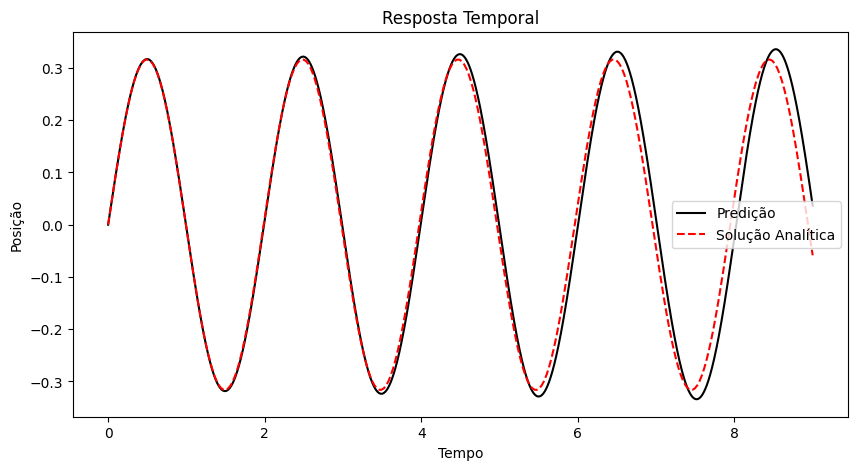

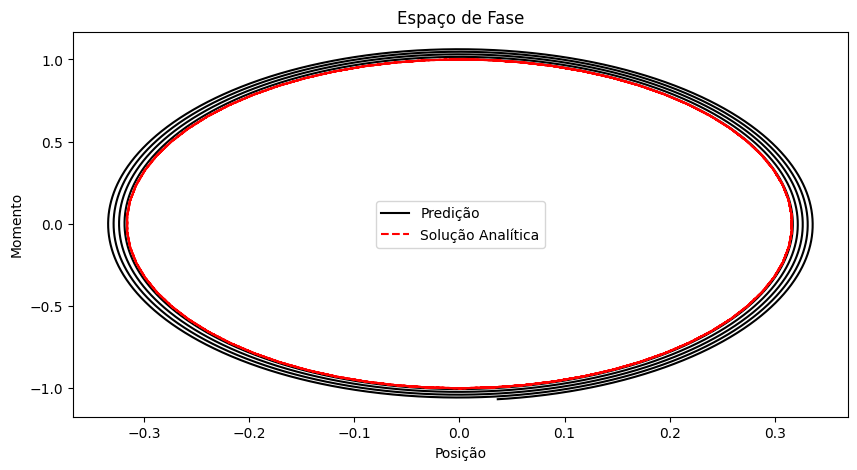

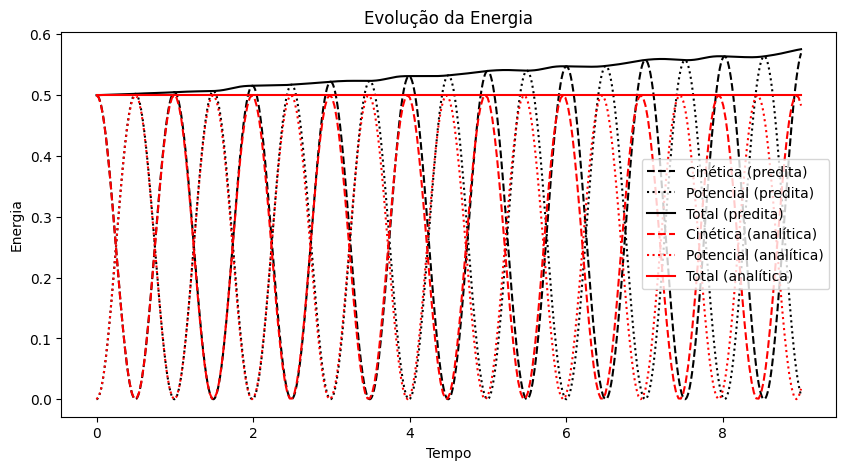

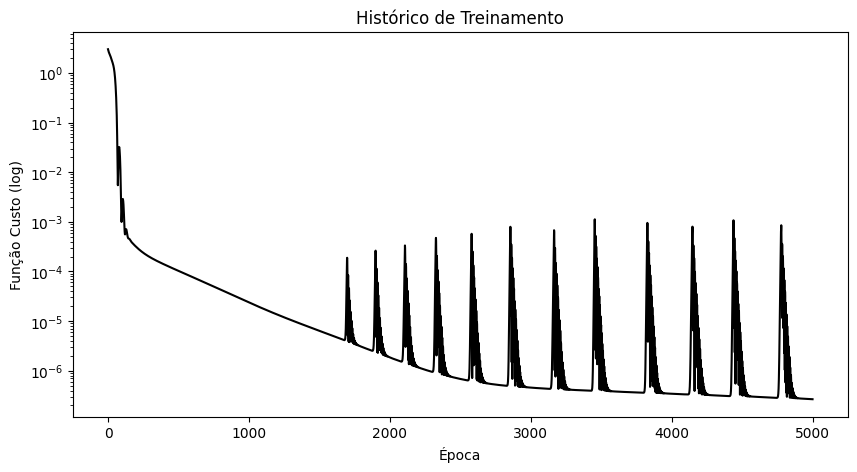

In [2]:
# Importação das bibliotecas necessárias
import torch  # Framework para redes neurais
import numpy as np  # Operações numéricas
from torch.autograd import grad  # Cálculo de derivadas automáticas
import matplotlib.pyplot as plt  # Visualização de gráficos

# Configuração da semente aleatória para reprodutibilidade
torch.manual_seed(2)

# ==============================================================================
# CONFIGURAÇÕES DO USUÁRIO
# ==============================================================================

# Parâmetros físicos do sistema massa-mola
dx0dt = 1  # Velocidade inicial
k = 10     # Constante elástica da mola
m = 1      # Massa do objeto

# Parâmetros de amostragem para treinamento
tmaxTraining = 1.5  # Tempo máximo para dados de treino
numberOfTrainingSamples = 50  # Número de amostras de treino

# Parâmetros de amostragem para validação
tmaxValidation = 9  # Tempo máximo para dados de validação
numberOfValidationSamples = 300  # Número de amostras de validação

# Arquitetura da rede neural
neurons = 50  # Número de neurônios por camada oculta
layers = 2    # Número de camadas ocultas

# Hiperparâmetros de treinamento
lr = 1e-3    # Taxa de aprendizado (learning rate)
epochs = 5000  # Número de épocas de treinamento

# ==============================================================================
# IMPLEMENTAÇÃO DA REDE NEURAL
# ==============================================================================

class FNN(torch.nn.Module):
    """Rede Neural Feedforward para modelar o sistema dinâmico."""

    def __init__(self, inputSize, outputSize, neurons, layers):
        """
        Inicializa a rede neural.

        Args:
            inputSize: Dimensão da entrada (2 para posição e momento)
            outputSize: Dimensão da saída (2 para derivadas)
            neurons: Número de neurônios nas camadas ocultas
            layers: Número de camadas ocultas
        """
        super().__init__()
        self.layers = layers

        # Camada de entrada
        self.linear1 = torch.nn.Linear(inputSize, neurons)

        # Camadas ocultas (armazenadas em ModuleList)
        self.linear2 = torch.nn.ModuleList()
        for _ in range(self.layers):
            self.linear2.append(torch.nn.Linear(neurons, neurons))

        # Camada de saída
        self.linear3 = torch.nn.Linear(neurons, outputSize)

        # Função de ativação
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        """Passagem forward através da rede."""
        y = self.activation(self.linear1(x))  # Primeira camada

        # Camadas ocultas
        for i in range(self.layers):
            y = self.activation(self.linear2[i](y))

        # Camada de saída (sem ativação)
        y = self.linear3(y)
        return y

# ==============================================================================
# FUNÇÃO PARA CÁLCULO DE DERIVADAS
# ==============================================================================

def getDerivative(y, x, n):
    """
    Calcula a derivada de ordem n de y em relação a x usando autograd.

    Args:
        y: Tensor dependente
        x: Tensor independente
        n: Ordem da derivada

    Returns:
        Tensor com a derivada de ordem n
    """
    if n == 0:
        return y
    else:
        # Calcula derivada primeira
        dy_dx = grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n-1)  # Chamada recursiva para derivadas superiores

# ==============================================================================
# GERAÇÃO DOS DADOS - SOLUÇÃO ANALÍTICA
# ==============================================================================

# Parâmetros da solução analítica
omega = np.sqrt(k / m)  # Frequência angular
A = dx0dt / omega       # Amplitude do movimento
phi = 0                 # Fase inicial

# Funções da solução analítica
x = lambda t: A * np.sin(omega * t + phi)  # Posição em função do tempo
dxdt = lambda t: omega * A * np.cos(omega * t + phi)  # Velocidade
ddxdtt = lambda t: - omega ** 2 * A * np.sin(omega * t + phi)  # Aceleração

# ==============================================================================
# PREPARAÇÃO DOS DADOS DE TREINAMENTO
# ==============================================================================

# Gera tempos para treinamento
tTraining = np.linspace(0, tmaxTraining, numberOfTrainingSamples)

# Empilha os dados de treino: posição, momento (m*velocidade) e força (m*aceleração)
trainingData = torch.vstack((
    torch.from_numpy(x(tTraining)),           # Posição (x)
    m * torch.from_numpy(dxdt(tTraining)),    # Momento (p = m*v)
    m * torch.from_numpy(ddxdtt(tTraining))   # Força (F = m*a)
)).to(torch.float32).T  # Converte para tensor e transpõe

# ==============================================================================
# PREPARAÇÃO DOS DADOS DE VALIDAÇÃO
# ==============================================================================

# Gera tempos para validação (intervalo maior)
tValidation = np.linspace(0, tmaxValidation, numberOfValidationSamples)

# Empilha os dados de validação
validationData = torch.vstack((
    torch.from_numpy(x(tValidation)),
    m * torch.from_numpy(dxdt(tValidation)),
    m * torch.from_numpy(ddxdtt(tValidation))
)).to(torch.float32).T

# ==============================================================================
# PREPARAÇÃO DA ENTRADA DO MODELO
# ==============================================================================

# Dados de treino: posição e momento
modelInputTraining = trainingData[:, :2]
modelInputTraining.requires_grad = True  # Habilita cálculo de gradientes

# Dados de validação: posição e momento
modelInputValidation = validationData[:, :2]
modelInputValidation.requires_grad = True

# ==============================================================================
# TREINAMENTO SUPERVISIONADO
# ==============================================================================

# Inicialização do modelo e otimizador
model = FNN(2, 2, neurons, layers)  # 2 entradas (x,p), 2 saídas (dx/dt, dp/dt)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
costHistory = np.zeros(epochs)  # Para armazenar histórico do custo

# Loop de treinamento
for epoch in range(epochs):
    optimizer.zero_grad()  # Zera os gradientes

    # Predição do modelo (velocidade e força)
    xPred = model(modelInputTraining)

    # Cálculo do custo (erro quadrático médio)
    cost = torch.mean((xPred - trainingData[:, 1:]) ** 2)
    costHistory[epoch] = cost.detach()  # Armazena o custo

    # Backpropagation
    cost.backward()
    optimizer.step()  # Atualiza os pesos

    # Exibe progresso a cada 50 épocas
    if epoch % 50 == 0:
        print(f"Época: {epoch}/{epochs}\tFunção custo: {cost.detach():.3E}")

# ==============================================================================
# PÓS-PROCESSAMENTO E SIMULAÇÃO
# ==============================================================================

# Configuração da integração numérica
numberOfTimeSteps = 10000  # Número de passos de integração
tPrediction = np.linspace(0, tmaxValidation, numberOfTimeSteps + 1)
dt = tmaxValidation / numberOfTimeSteps  # Tamanho do passo de tempo

# Inicialização das variáveis para integração
xPrediction = torch.zeros((2, numberOfTimeSteps + 1), requires_grad=False)
xPrediction[:, 0] = validationData[0, :2]  # Condições iniciais

# Integração numérica usando o método de Euler
for i in range(numberOfTimeSteps):
    # Prediz as derivadas usando o modelo treinado
    derivatives = model(xPrediction[:, i])

    # Atualiza posição e momento usando o método de Euler
    xPrediction[:, i + 1] = (xPrediction[:, i] + dt * derivatives).detach()

# ==============================================================================
# VISUALIZAÇÃO DOS RESULTADOS
# ==============================================================================

# 1. Resposta temporal da posição
plt.figure(figsize=(10, 5))
plt.plot(tPrediction, xPrediction[0, :], 'k', label="Predição")
plt.plot(tValidation, validationData[:, 0], 'r--', label="Solução Analítica")
plt.xlabel("Tempo")
plt.ylabel("Posição")
plt.legend()
plt.title("Resposta Temporal")
plt.show()

# 2. Espaço de fase (posição vs momento)
plt.figure(figsize=(10, 5))
plt.plot(xPrediction[0, :], xPrediction[1, :], 'k', label="Predição")
plt.plot(validationData[:, 0], validationData[:, 1], 'r--', label="Solução Analítica")
plt.xlabel("Posição")
plt.ylabel("Momento")
plt.legend()
plt.title("Espaço de Fase")
plt.show()

# 3. Evolução das energias
plt.figure(figsize=(10, 5))
# Energias preditas
plt.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2, 'k--', label="Cinética (predita)")
plt.plot(tPrediction, 0.5 * k * xPrediction[0, :] ** 2, 'k:', label="Potencial (predita)")
plt.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2 + 0.5 * k * xPrediction[0, :] ** 2, 'k', label="Total (predita)")

# Energias analíticas
plt.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2, 'r--', label="Cinética (analítica)")
plt.plot(tValidation, 0.5 * k * validationData[:, 0] ** 2, 'r:', label="Potencial (analítica)")
plt.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2 + 0.5 * k * validationData[:, 0] ** 2, 'r', label="Total (analítica)")

plt.xlabel("Tempo")
plt.ylabel("Energia")
plt.legend()
plt.title("Evolução da Energia")
plt.show()

# 4. Histórico de treinamento
plt.figure(figsize=(10, 5))
plt.plot(costHistory, 'k')
plt.yscale('log')  # Escala logarítmica para melhor visualização
plt.xlabel("Época")
plt.ylabel("Função Custo (log)")
plt.title("Histórico de Treinamento")
plt.show()